# Imports + chemins + paramètres

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report, confusion_matrix

print("TensorFlow version:", tf.__version__)

# ===============================
# 1. Paths & constants
# ===============================
DATASET_DIR = "/kaggle/input/dataset-root/output"   # change if needed

TRAIN_DIR = os.path.join(DATASET_DIR, "train")
VAL_DIR   = os.path.join(DATASET_DIR, "val")
TEST_DIR  = os.path.join(DATASET_DIR, "test")

IMG_HEIGHT = 224
IMG_WIDTH  = 224
BATCH_SIZE = 32
SEED       = 42
NUM_CLASSES = 3

2025-12-05 13:44:20.743910: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764942261.118989      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764942261.242826      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

TensorFlow version: 2.18.0


# Data generators (baseline CNN)

In [2]:
def get_data_generators():
    """
    Generators for the custom CNN:
    - TRAIN: rescale + data augmentation
    - VAL/TEST: rescale only
    """
    train_datagen = ImageDataGenerator(
        rescale=1.0 / 255,
        rotation_range=20,
        width_shift_range=0.15,
        height_shift_range=0.15,
        zoom_range=0.2,
        horizontal_flip=True,
        brightness_range=[0.8, 1.2],
        shear_range=0.15
    )

    val_test_datagen = ImageDataGenerator(rescale=1.0 / 255)

    train_gen = train_datagen.flow_from_directory(
        TRAIN_DIR,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode="categorical",
        shuffle=True,
        seed=SEED
    )

    val_gen = val_test_datagen.flow_from_directory(
        VAL_DIR,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode="categorical",
        shuffle=False
    )

    test_gen = val_test_datagen.flow_from_directory(
        TEST_DIR,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode="categorical",
        shuffle=False
    )

    print("Classes détectées :", train_gen.class_indices)
    print("Train:", train_gen.n, "| Val:", val_gen.n, "| Test:", test_gen.n)

    return train_gen, val_gen, test_gen

train_gen, val_gen, test_gen = get_data_generators()

Found 3124 images belonging to 3 classes.
Found 389 images belonging to 3 classes.
Found 394 images belonging to 3 classes.
Classes détectées : {'alert': 0, 'non_vigilant': 1, 'tired': 2}
Train: 3124 | Val: 389 | Test: 394


# Anti-overfitting CNN baseline

In [3]:
def build_cnn_baseline():
    weight_decay = 1e-4

    model = keras.Sequential([
        layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),

        layers.Conv2D(32, (3,3), padding='same', activation='relu',
                      kernel_regularizer=regularizers.l2(weight_decay)),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2,2),

        layers.Conv2D(64, (3,3), padding='same', activation='relu',
                      kernel_regularizer=regularizers.l2(weight_decay)),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2,2),

        layers.Conv2D(128, (3,3), padding='same', activation='relu',
                      kernel_regularizer=regularizers.l2(weight_decay)),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2,2),

        layers.Conv2D(256, (3,3), padding='same', activation='relu',
                      kernel_regularizer=regularizers.l2(weight_decay)),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2,2),

        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu',
                     kernel_regularizer=regularizers.l2(weight_decay)),
        layers.Dropout(0.5),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

cnn_model = build_cnn_baseline()
cnn_model.summary()

I0000 00:00:1764942285.452772      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1764942285.453493      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     6,422,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,813,379 (25.99 MB)

 Trainable params: 6,812,419 (25.99 MB)

 Non-trainable params: 960 (3.75 KB)

# Callbacks

In [4]:
def make_callbacks(model_name):
    os.makedirs("models", exist_ok=True)

    checkpoint_cb = keras.callbacks.ModelCheckpoint(
        f"models/{model_name}.keras",
        monitor="val_accuracy",
        save_best_only=True,
        verbose=1
    )

    earlystop_cb = keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True,
        verbose=1
    )

    lr_cb = keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=2,
        min_lr=1e-6,
        verbose=1
    )

    return [checkpoint_cb, earlystop_cb, lr_cb]

# Train CNN baseline

In [5]:
cnn_callbacks = make_callbacks("fatigue_cnn_baseline")

history_cnn = cnn_model.fit(
    train_gen,
    epochs=30,
    validation_data=val_gen,
    callbacks=cnn_callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


I0000 00:00:1764942293.186185     131 service.cc:148] XLA service 0x7e1370015600 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764942293.187854     131 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1764942293.187877     131 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1764942293.848471     131 cuda_dnn.cc:529] Loaded cuDNN version 90300


 2/98 ━━━━━━━━━━━━━━━━━━━━ 7s 82ms/step - accuracy: 0.3672 - loss: 2.7795  

I0000 00:00:1764942301.903128     131 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 812ms/step - accuracy: 0.3939 - loss: 2.2173
Epoch 1: val_accuracy improved from -inf to 0.36761, saving model to models/fatigue_cnn_baseline.keras
98/98 ━━━━━━━━━━━━━━━━━━━━ 101s 908ms/step - accuracy: 0.3942 - loss: 2.2108 - val_accuracy: 0.3676 - val_loss: 5.7601 - learning_rate: 1.0000e-04
Epoch 2/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 591ms/step - accuracy: 0.4791 - loss: 1.0531
Epoch 2: val_accuracy did not improve from 0.36761
98/98 ━━━━━━━━━━━━━━━━━━━━ 61s 625ms/step - accuracy: 0.4793 - loss: 1.0530 - val_accuracy: 0.3676 - val_loss: 10.4411 - learning_rate: 1.0000e-04
Epoch 3/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 590ms/step - accuracy: 0.5125 - loss: 1.0081
Epoch 3: val_accuracy did not improve from 0.36761

Epoch 3: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
98/98 ━━━━━━━━━━━━━━━━━━━━ 61s 623ms/step - accuracy: 0.5127 - loss: 1.0080 - val_accuracy: 0.3676 - val_loss: 7.0916 - learning_rate: 1.0000e-04
Epoch 4/30
98/98 ━━━━━━━━━━━━━━

- Plot curves

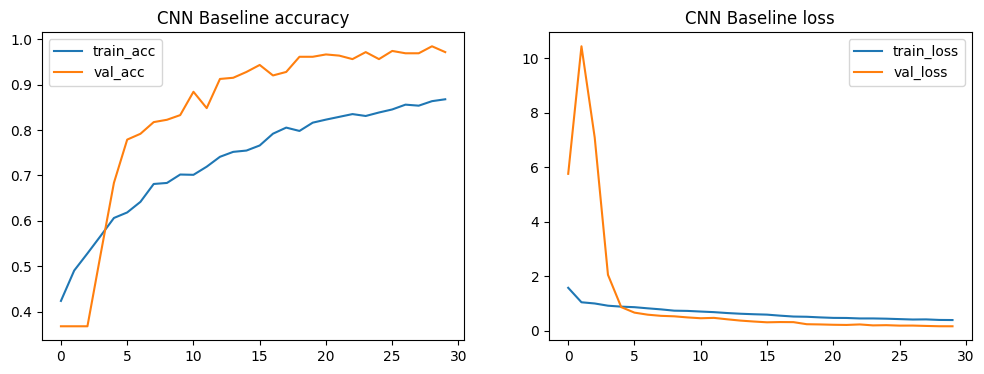

In [6]:
def plot_history(history, title="Model"):
    plt.figure(figsize=(12,4))
    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history["accuracy"], label="train_acc")
    plt.plot(history.history["val_accuracy"], label="val_acc")
    plt.title(f"{title} accuracy")
    plt.legend()
    # Loss
    plt.subplot(1,2,2)
    plt.plot(history.history["loss"], label="train_loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.title(f"{title} loss")
    plt.legend()
    plt.show()

plot_history(history_cnn, "CNN Baseline")

# Transfer learning generators with custom preprocessing

In [7]:
def get_generators_with_preprocess(preprocess_fn, augment=True):
    if augment:
        train_datagen = ImageDataGenerator(
            preprocessing_function=preprocess_fn,
            rotation_range=15,
            width_shift_range=0.1,
            height_shift_range=0.1,
            zoom_range=0.1,
            horizontal_flip=True
        )
    else:
        train_datagen = ImageDataGenerator(preprocessing_function=preprocess_fn)

    val_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_fn)

    train_gen = train_datagen.flow_from_directory(
        TRAIN_DIR,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode="categorical",
        shuffle=True,
        seed=SEED
    )

    val_gen = val_test_datagen.flow_from_directory(
        VAL_DIR,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode="categorical",
        shuffle=False
    )

    test_gen = val_test_datagen.flow_from_directory(
        TEST_DIR,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode="categorical",
        shuffle=False
    )

    return train_gen, val_gen, test_gen

# EfficientNetB0 model

Found 3124 images belonging to 3 classes.
Found 389 images belonging to 3 classes.
Found 394 images belonging to 3 classes.
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,213,926 (16.07 MB)

 Trainable params: 164,355 (642.01 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

Epoch 1/25
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 606ms/step - accuracy: 0.3358 - loss: 1.3030
Epoch 1: val_accuracy improved from -inf to 0.52185, saving model to models/fatigue_effnetb0.keras
98/98 ━━━━━━━━━━━━━━━━━━━━ 94s 752ms/step - accuracy: 0.3361 - loss: 1.3023 - val_accuracy: 0.5219 - val_loss: 1.0397 - learning_rate: 1.0000e-04
Epoch 2/25
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 519ms/step - accuracy: 0.4082 - loss: 1.1426
Epoch 2: val_accuracy improved from 0.52185 to 0.61183, saving model to models/fatigue_effnetb0.keras
98/98 ━━━━━━━━━━━━━━━━━━━━ 55s 559ms/step - accuracy: 0.4084 - loss: 1.1424 - val_accuracy: 0.6118 - val_loss: 0.9718 - learning_rate: 1.0000e-04
Epoch 3/25
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 513ms/step - accuracy: 0.4643 - loss: 1.0513
Epoch 3: val_accuracy improved from 0.61183 to 0.66581, saving model to models/fatigue_effnetb0.keras
98/98 ━━━━━━━━━━━━━━━━━━━━ 54s 552ms/step - accuracy: 0.4646 - loss: 1.0511 - val_accuracy: 0.6658 - val_loss: 0.9195 - learning_rate: 1.0000e-04
E

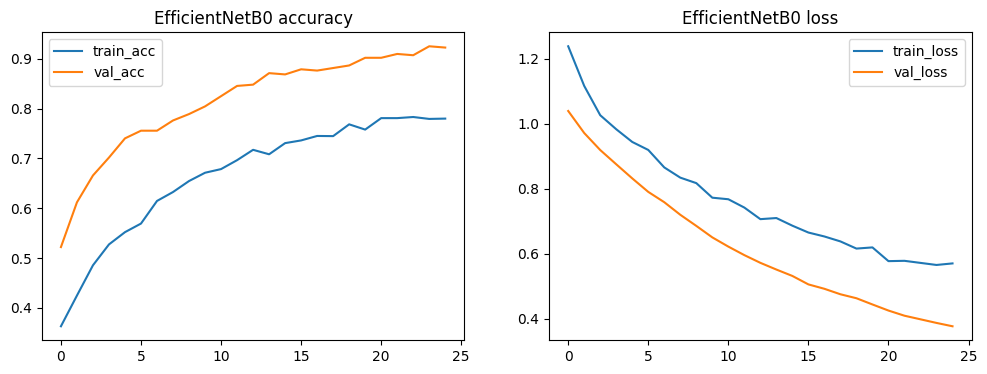

In [8]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input as effb0_preprocess

def build_effnetb0_model():
    base = EfficientNetB0(
        include_top=False,
        weights="imagenet",
        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
    )
    base.trainable = False   # phase 1: feature extractor

    x = base.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation="relu",
                     kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

    model = keras.Model(inputs=base.input, outputs=outputs)

    model.compile(
        optimizer=keras.optimizers.Adam(1e-4),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

train_gen_eff, val_gen_eff, test_gen_eff = get_generators_with_preprocess(
    effb0_preprocess,
    augment=True
)

effnet_model = build_effnetb0_model()
effnet_model.summary()

eff_callbacks = make_callbacks("fatigue_effnetb0")

history_eff = effnet_model.fit(
    train_gen_eff,
    epochs=25,
    validation_data=val_gen_eff,
    callbacks=eff_callbacks
)

plot_history(history_eff, "EfficientNetB0")

# MobileNetV2 model

Found 3124 images belonging to 3 classes.
Found 389 images belonging to 3 classes.
Found 394 images belonging to 3 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,339 (9.24 MB)

 Trainable params: 164,355 (642.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/25
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 558ms/step - accuracy: 0.3252 - loss: 1.6759
Epoch 1: val_accuracy improved from -inf to 0.47044, saving model to models/fatigue_mobilenetv2.keras
98/98 ━━━━━━━━━━━━━━━━━━━━ 73s 657ms/step - accuracy: 0.3255 - loss: 1.6745 - val_accuracy: 0.4704 - val_loss: 1.0425 - learning_rate: 1.0000e-04
Epoch 2/25
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 533ms/step - accuracy: 0.3888 - loss: 1.2955
Epoch 2: val_accuracy improved from 0.47044 to 0.52699, saving model to models/fatigue_mobilenetv2.keras
98/98 ━━━━━━━━━━━━━━━━━━━━ 56s 573ms/step - accuracy: 0.3889 - loss: 1.2950 - val_accuracy: 0.5270 - val_loss: 1.0091 - learning_rate: 1.0000e-04
Epoch 3/25
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 535ms/step - accuracy: 0.4088 - loss: 1.1581
Epoch 3: val_accuracy improved from 0.52699 to 0.61697, saving model to models/fatigue_mobilenetv2.keras
98/98 ━━━━━━━━━━━━━━━━━━━━ 56s 574ms/step - accuracy: 0.4091 - loss: 1.1580 - val_accuracy: 0.6170 - val_loss: 0.9952 - learning_rate: 1.0

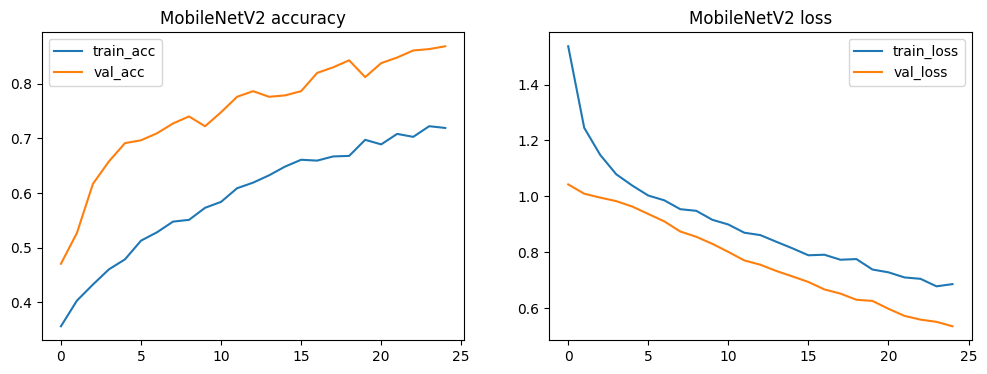

In [9]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess

def build_mobilenet_model():
    base = MobileNetV2(
        include_top=False,
        weights="imagenet",
        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
    )
    base.trainable = False

    x = base.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation="relu",
                     kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

    model = keras.Model(inputs=base.input, outputs=outputs)

    model.compile(
        optimizer=keras.optimizers.Adam(1e-4),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

train_gen_mob, val_gen_mob, test_gen_mob = get_generators_with_preprocess(
    mobilenet_preprocess,
    augment=True
)

mobilenet_model = build_mobilenet_model()
mobilenet_model.summary()

mob_callbacks = make_callbacks("fatigue_mobilenetv2")

history_mob = mobilenet_model.fit(
    train_gen_mob,
    epochs=25,
    validation_data=val_gen_mob,
    callbacks=mob_callbacks
)

plot_history(history_mob, "MobileNetV2")

# InceptionV3 model

Found 3124 images belonging to 3 classes.
Found 389 images belonging to 3 classes.
Found 394 images belonging to 3 classes.
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 111, 111,  │        864 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 111, 111,  │         96 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 109, 109,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 109, 109,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 54, 54,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 54, 54,    │      5,120 │ max_pooling2d_4[… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 52, 52,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_8[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 22,065,443 (84.17 MB)

 Trainable params: 262,659 (1.00 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

Epoch 1/25
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 637ms/step - accuracy: 0.3468 - loss: 1.7229
Epoch 1: val_accuracy improved from -inf to 0.49614, saving model to models/fatigue_inceptionv3.keras
98/98 ━━━━━━━━━━━━━━━━━━━━ 95s 797ms/step - accuracy: 0.3469 - loss: 1.7207 - val_accuracy: 0.4961 - val_loss: 1.0495 - learning_rate: 1.0000e-04
Epoch 2/25
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 585ms/step - accuracy: 0.3966 - loss: 1.2241
Epoch 2: val_accuracy improved from 0.49614 to 0.52185, saving model to models/fatigue_inceptionv3.keras
98/98 ━━━━━━━━━━━━━━━━━━━━ 62s 634ms/step - accuracy: 0.3966 - loss: 1.2237 - val_accuracy: 0.5219 - val_loss: 1.0508 - learning_rate: 1.0000e-04
Epoch 3/25
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 592ms/step - accuracy: 0.4322 - loss: 1.0941
Epoch 3: val_accuracy did not improve from 0.52185
98/98 ━━━━━━━━━━━━━━━━━━━━ 62s 631ms/step - accuracy: 0.4321 - loss: 1.0941 - val_accuracy: 0.5219 - val_loss: 1.0477 - learning_rate: 1.0000e-04
Epoch 4/25
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 595ms

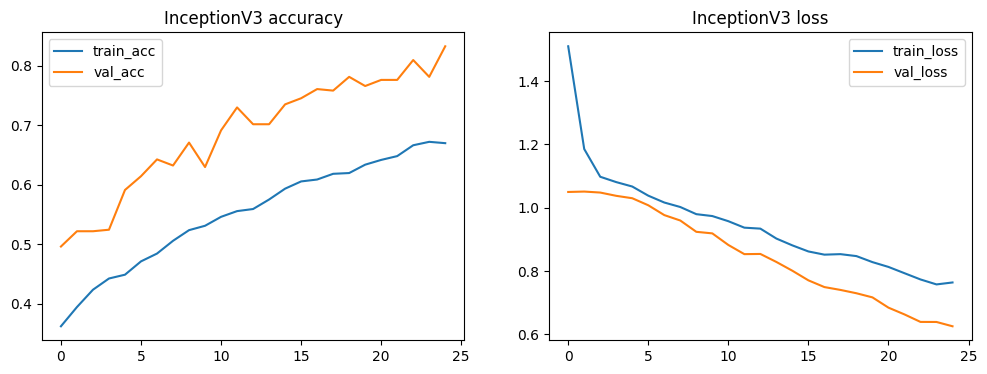

In [10]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_preprocess

def build_inception_model():
    base = InceptionV3(
        include_top=False,
        weights="imagenet",
        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
    )
    base.trainable = False   # Transfer learning phase 1

    x = base.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)

    # Regularization block
    x = layers.Dense(128, activation="relu",
                     kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

    model = keras.Model(inputs=base.input, outputs=outputs)

    model.compile(
        optimizer=keras.optimizers.Adam(1e-4),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model


# Generators (with preprocessing & augmentation)
train_gen_inc, val_gen_inc, test_gen_inc = get_generators_with_preprocess(
    inception_preprocess,
    augment=True
)

# Build the model
inception_model = build_inception_model()
inception_model.summary()

# Callbacks
inc_callbacks = make_callbacks("fatigue_inceptionv3")

# Train
history_inc = inception_model.fit(
    train_gen_inc,
    epochs=25,
    validation_data=val_gen_inc,
    callbacks=inc_callbacks
)

# Plot curves
plot_history(history_inc, "InceptionV3")


# Final evaluation on test set

In [11]:
# Load best weights
cnn_best        = keras.models.load_model("models/fatigue_cnn_baseline.keras")
effnet_best     = keras.models.load_model("models/fatigue_effnetb0.keras")
mobilenet_best  = keras.models.load_model("models/fatigue_mobilenetv2.keras")
inception_best  = keras.models.load_model("models/fatigue_inceptionv3.keras")

# Evaluate each model
_, acc_cnn       = cnn_best.evaluate(test_gen,          verbose=0)
_, acc_effnet    = effnet_best.evaluate(test_gen_eff,   verbose=0)
_, acc_mobil     = mobilenet_best.evaluate(test_gen_mob, verbose=0)
_, acc_inception = inception_best.evaluate(test_gen_inc, verbose=0)

results = {
    "CNN baseline (regul.)" : acc_cnn,
    "EfficientNetB0"        : acc_effnet,
    "MobileNetV2"           : acc_mobil,
    "InceptionV3"           : acc_inception,
}

for name, acc in results.items():
    print(f"{name:22s} : {acc:.4f}")

# Choose the best model manually
best_model      = inception_best    # example (change depending on results)
best_test_gen   = test_gen_inc
y_true          = best_test_gen.classes
y_pred          = np.argmax(best_model.predict(best_test_gen), axis=1)

print("\nClassification report:")
print(classification_report(y_true, y_pred,
                            target_names=best_test_gen.class_indices.keys()))

CNN baseline (regul.)  : 0.9822
EfficientNetB0         : 0.9010
MobileNetV2            : 0.8731
InceptionV3            : 0.8147
13/13 ━━━━━━━━━━━━━━━━━━━━ 14s 664ms/step

Classification report:
              precision    recall  f1-score   support

       alert       0.78      0.85      0.81       126
non_vigilant       0.90      0.69      0.78       123
       tired       0.80      0.89      0.84       145

    accuracy                           0.81       394
   macro avg       0.83      0.81      0.81       394
weighted avg       0.82      0.81      0.81       394

